# The analog-horror solvepath

`analog-horror` is a challenge involving an audio file in the style of an EAS (Emergency Alert System) message.

[EAS alerts are composed of a digital SAME header encoded in the waveform, an attention tone, and an audio message.](https://en.wikipedia.org/wiki/Emergency_Alert_System) It is these (albeit slightly non-standard as a result of the `same-encoder` library's precision issue) SAME headers that we want to decode.

[SAME headers](https://en.wikipedia.org/wiki/Specific_Area_Message_Encoding) are encoded using a technique called [frequency-shift keying](https://en.wikipedia.org/wiki/Frequency-shift_keying), where bits are denoted by different frequencies in the signal over bit periods of 1.927437642 mi-lliseconds. Zooming in on a waveform, we can see these signals up close, with two slightly different frequencies:

(Yes, this code is very messy.)

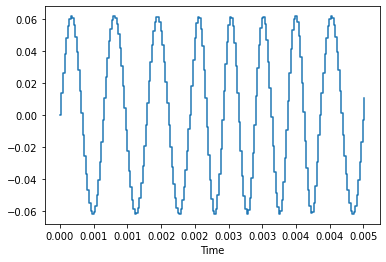

In [3]:
# imports
from __future__ import print_function # I got this code from somewhere (I think a Stack Overflow question?) that was apparently using Python 2
import librosa
import librosa.display
import numpy as np

# Load local audio file
y, sr = librosa.load('fake-alert.wav', sr=44100)

# Trim the audio file to just the SAME alert portion
y = y[0:40120]

librosa.display.waveshow(y[0:200], sr=sr)

With this, we can programmatically decode the signal into a readable flag. (There are other ways you could do it, including *cough cough b1c* manually by looking at the spectrogram, but that's out of the scope of this writeup.)

First, we find the locations where the waveform changes sign.

The code refers to these as "peaks" because it was written differently before.

In [4]:
peaks_only = []
for i in range(np.shape(y)[0] - 1):
    if y[i] == 0 or y[i + 1] == 0:
        peaks_only.append(False)
    elif np.sign(y[i]) != np.sign(y[i + 1]):
        peaks_only.append(True)
    else:
        peaks_only.append(False)

We calculate these locations relative to the bit period.

In [5]:
peaks = []
is_in_peak = False
for i in range(np.shape(y)[0] - 1):
    if peaks_only[i]:
        if not is_in_peak:
            is_in_peak = True
            peaks.append(i / (0.001927437642 * sr))
    else:
        is_in_peak = False

print(peaks[len(peaks) - 1])

471.8235293440441


Now, we find the time between each of these changes, effectively giving us the period/frequency of the waveform.

In [6]:
margin = 0.2
period = []
for i in range(472):
    current = []
    for j in range(len(peaks)):
        if j + 1 >= len(peaks):
            break
        if peaks[j] >= i + margin:
            current.append(peaks[j + 1] - peaks[j])
        if peaks[j + 1] >= i + 1 - margin:
            break
    period.append(sum(current) / len(current))
print(len(period))

472


Let's check the periods. If we get two discrete values, we did things correctly. (This is where I found out about that precision issue.)

In [7]:
period

[0.16470588232930103,
 0.1247058823350422,
 0.16470588232930097,
 0.16470588232930097,
 0.16470588232930114,
 0.12470588233504235,
 0.12470588233504235,
 0.16470588232930083,
 0.12470588233504216,
 0.12470588233504216,
 0.16470588232930083,
 0.16470588232930142,
 0.16470588232930142,
 0.12470588233504251,
 0.12470588233504251,
 0.16470588232930083,
 0.12470588233504216,
 0.16470588232930083,
 0.16470588232930083,
 0.16470588232930083,
 0.16470588232930083,
 0.12470588233504216,
 0.12470588233504216,
 0.16470588232930083,
 0.12470588233504216,
 0.12470588233504216,
 0.16470588232930083,
 0.16470588232930203,
 0.16470588232930203,
 0.12470588233504287,
 0.12470588233504287,
 0.16470588232930083,
 0.16470588232930083,
 0.16470588232930083,
 0.12470588233504146,
 0.16470588232930083,
 0.12470588233504146,
 0.12470588233504146,
 0.12470588233504146,
 0.16470588232930083,
 0.16470588232930083,
 0.12470588233504287,
 0.12470588233504287,
 0.16470588232930083,
 0.16470588232930083,
 0.12470588

Finally, let's get the result in binary by looping over all the bit periods. We'll then reverse each byte to correct the endianness.

In [8]:
threshold = 0.15
result = "".join(["0" if x > threshold else "1" for x in period])

# Reverse every byte
result = result[::-1]
print("".join(chr(int(result[i:i+8], 2)) for i in reversed(range(0, len(result), 8))))

bcactf{time_to_get_fined_by_the_fcc_0JIBKejZdfEknGQkRcPxCg}


Pop this into CyberChef, and we have the flag!